# 基于随机森林方法的滑坡易发性评价

 Load an imbalanced dataset
 --------------------------

 We will load the wanzhou dataset which has an imbalanced ratio of 19:1
 (number of majority sample for a minority sample). The data are then split
 into training and testing.

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, scale
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils import compute_class_weight

data = pd.read_csv('./data/wanzhou_island.csv')
target = 'value'
IDCol = 'ID'
GeoID = data[IDCol]
print(data[target].value_counts())
x_columns = ['Elevation', 'Slope', 'Aspect', 'TRI', 'Curvature', 'Lithology', 'River', 'NDVI', 'NDWI', 'Rainfall', 'Earthquake', 'Land_use']

X = data[x_columns]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,stratify=y, random_state=0)


0    553172
1     29313
Name: value, dtype: int64


三种随机森林建模

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
stdscaler = StandardScaler()
pca = PCA(n_components='mle')

num_pipe = make_pipeline(
    stdscaler, 
    SimpleImputer(strategy="mean", add_indicator=True), 
    pca
)
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor_tree = make_column_transformer(
    (num_pipe, selector(dtype_include="number")),
    (cat_pipe, selector(dtype_include="category")),
    n_jobs=2,
)

rf_clf = make_pipeline(
    preprocessor_tree, RandomForestClassifier(random_state=42, n_jobs=-1)
)

weighted_rf_clf = make_pipeline(
    preprocessor_tree, RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
)

brf = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)
balanced_rf_clf = make_pipeline(preprocessor_tree, brf)

rf_clf.fit(X_train, y_train)
y_pred_rf_clf = rf_clf.predict(X_test)
y_prob_rf_clf = rf_clf.predict_proba(X_test)

weighted_rf_clf.fit(X_train, y_train)
y_pred_weighted_rf_clf = weighted_rf_clf.predict(X_test)
y_prob_weighted_rf_clf = weighted_rf_clf.predict_proba(X_test)

balanced_rf_clf.fit(X_train, y_train)
y_pred_balanced_rf_clf = balanced_rf_clf.predict(X_test)
y_prob_balanced_rf_clf = balanced_rf_clf.predict_proba(X_test)



绘制测试集ROC曲线

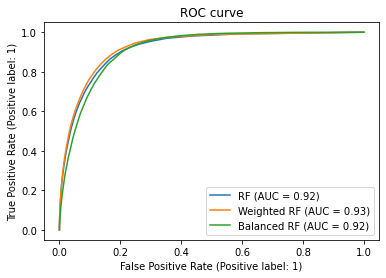

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()

models = [
    ("RF", rf_clf),
    ("Weighted RF", weighted_rf_clf),
    ("Balanced RF", balanced_rf_clf),
]

for name, pipeline in models:
    RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=ax, name=name
    )
_ = ax.set_title("ROC curve")
plt.show()

训练集ROC曲线

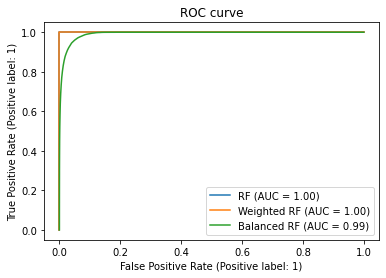

In [4]:
fig, ax = plt.subplots()
for name, pipeline in models:
    RocCurveDisplay.from_estimator(pipeline, X_train, y_train, ax=ax, name=name
    )
_ = ax.set_title("ROC curve")
plt.show()

Balanced Score And Accuracy分数

In [5]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import (accuracy_score, auc, balanced_accuracy_score,
                             classification_report, confusion_matrix,
                             recall_score, roc_auc_score, roc_curve)
index = []
scores = {"Accuracy": [], "Balanced accuracy": []}
scoring = ["accuracy", "balanced_accuracy"]

model_pred = [
    ("RF", y_pred_rf_clf),
    ("Weighted RF", y_pred_weighted_rf_clf),
    ("Balanced RF", y_pred_balanced_rf_clf),
]

for model_name, pred in model_pred:
      scores["Accuracy"].append(accuracy_score(y_test, pred))
      scores["Balanced accuracy"].append(balanced_accuracy_score(y_test, pred))
      index.append(model_name)

df_scores = pd.DataFrame(scores,index=index)
df_scores


,Accuracy,Balanced accuracy
RF,0.952840,0.543948
Weighted RF,0.952711,0.542386
Balanced RF,0.798600,0.847361


BalancedRandomForest生成全部样本LPI数据

In [6]:
import numpy as np
def save_results(GeoID, y_pred, y_predprob, result_file):
    results = np.vstack((GeoID,y_pred,y_predprob))
    results = np.transpose(results)
    header_string = 'GeoID, y_pred, y_predprob'
    np.savetxt(result_file, results, header = header_string, fmt = '%d,%d,%0.5f',delimiter = ',')
    print('Saving file Done!')

y_prob_balanced_rf_clf = balanced_rf_clf.predict_proba(X)[:,1]
y_pred_balanced_rf_clf = balanced_rf_clf.predict(X)

result_file_balanced_rf_clf = './data/balanced_rf.txt'
save_results(GeoID, y_pred_balanced_rf_clf, y_prob_balanced_rf_clf, result_file_balanced_rf_clf)

Saving file Done!


RandomForest生成全部样本LPI数据

In [7]:
import numpy as np
def save_results(GeoID, y_pred, y_predprob, result_file):
    results = np.vstack((GeoID,y_pred,y_predprob))
    results = np.transpose(results)
    header_string = 'GeoID, y_pred, y_predprob'
    np.savetxt(result_file, results, header = header_string, fmt = '%d,%d,%0.5f',delimiter = ',')
    print('Saving file Done!')

y_prob_rf_clf = rf_clf.predict_proba(X)[:,1]
y_pred_rf_clf = rf_clf.predict(X)

result_file_rf_clf = './data/rf.txt'
save_results(GeoID, y_pred_rf_clf, y_prob_rf_clf, result_file_rf_clf)

Saving file Done!


接下来就是使用ArcGIS中的join方法连接样本数据和概率数据，再用概率数据转栅格，生成LPI图层，分类后即为易发性评价结果。

基于SHAP方法的模型可解释性分析

In [ ]:
import shap
shap.sample(X_train, 1000)
def model_predict(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=x_columns)
    return balanced_rf_clf.predict(data_asframe)
    
shap_kernel_explainer = shap.KernelExplainer(model_predict, X_train, link='logit')
shap_values_single = shap_kernel_explainer.shap_values(X_test.iloc[0,:])
shap.force_plot(shap_kernel_explainer.expected_value[0],np.array(shap_values_single[0]), X_test.iloc[0,:],link='logit')